# Notebook corresponding to case studies taken from MaveDB

In [2]:
import pandas as pd
from pathlib import Path
import os
base_path = Path("/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)")
list(base_path.glob("*.csv"))[:5]

[PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_003110.1.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005076.3.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_005493.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_057097.2.csv'),
 PosixPath('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')]

In [3]:
# Use a generator expression to read and concatenate CSVs
df = pd.concat((pd.read_csv(file) for file in base_path.rglob("*.csv")), ignore_index=True)
# df = pd.read_csv('/cta/share/users/ProteinGym/Clinical_Variants(Substitutions)/NP_055790.1.csv')

df_benign = df[df["DMS_bin_score"] == "Benign"]
df_patho = df[df["DMS_bin_score"] == "Pathogenic"]
df_benign.head()

,Unnamed: 0,protein,protein_sequence,mutant,mutated_sequence,DMS_bin_score
0,67567,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R13G,MAVLLLLLRALRGGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
1,67568,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,G32E,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPEFPARPGRGRPYMAS...,Benign
2,67569,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,K113R,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
5,67572,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,V183I,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign
6,67573,NP_003110.1,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,R294H,MAVLLLLLRALRRGPGPGPRPLWGPGPAWSPGFPARPGRGRPYMAS...,Benign


In [ ]:
import numpy as np
from scipy.spatial.distance import pdist


'''
Given a Tokenizers encoding offsets offs
Assign each symbol in the sequence its token id
Return the numpy list containing assignments
(Like cluster assignments)
'''
def _offsets_to_cluster(offs):
    seq_len = offs[-1][-1]
    cluster_assign = np.zeros((seq_len, 1))
    for i, (b, e) in enumerate(offs):
        cluster_assign[b:e] = i
    return cluster_assign


# Cluster based rand-index
def calc_rand_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    rand_index = np.mean(assign_eq == label_eq)
    return rand_index

# Cluster based dice index
def calc_dice_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    dice_index = 2*TP / (2*TP + FP + FN + 1e-10)
    return dice_index

# Cluster based jaccard index
def calc_jaccard_index(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    # Boolean masks
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    # Jaccard index (ignores TN)
    jaccard_index = TP / (TP + FP + FN + 1e-10)
    return jaccard_index


# Calc all indices at the same time to avoid redundancy
# Returns rand, dice, jaccard
def calc_all_indices(offs1, offs2):
    clusters1 = _offsets_to_cluster(offs1)
    clusters2 = _offsets_to_cluster(offs2)
    assign_eq = pdist(clusters1, metric='hamming')  # 0 if same, 1 if different
    label_eq = pdist(clusters2, metric='hamming') # 0 if same, 1 if different
    same_assign = assign_eq == 0
    same_label = label_eq == 0
    TP = np.sum(same_assign & same_label)
    FP = np.sum(same_assign & ~same_label)
    FN = np.sum(~same_assign & same_label)
    TN = np.sum(~same_assign & ~same_label)


    jaccard_index = TP / (TP + FP + FN + 1e-10)
    dice_index = 2*TP / (2*TP + FP + FN + 1e-10)
    rand_index = (TP + TN) / (TP + FP + FN + TN)
    
    return rand_index, dice_index, jaccard_index





# Notlar
- Ayni kalan proteinler ne kadar ayni iki algoritma arasinda.
- DMS datasindaki, fonksiyonel olarak coherent butun parcalar ile bizim tokenlarimiz arasinda bir uyusma var mi diye incele

In [ ]:
encs1 = tkz2.encode_batch(df_patho["protein_sequence"])
encs2 = tkz2.encode_batch(df_patho["mutated_sequence"])

In [9]:
import os
import pickle

# If a small window in the tokenization is being considered
# return the offsets only belonging to that window, (first offset starting from 0)
def take_offsets_subset(offs, lower_idx, upper_idx):
    new_offsets = []
    for s,e in offs:
        start, end = 0, 0
        if e <= lower_idx:
            continue
        if s > upper_idx:
            continue
        if s < lower_idx:
            start = 0
        else:
            start = s - lower_idx
        if e > upper_idx:
            end = upper_idx - lower_idx + 1
        else:
            end = e - lower_idx
        new_offsets.append((start, end))
    return new_offsets

# Calculate all clustering analysis indices around a mutation position centered on a small window
# Window size should be odd
def calc_all_indices_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_all_indices(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_all_indices(new1, new2)
    
# Calculate Jaccard index around a mutation position centered on a small window
# Window size should be odd
def calc_jaccard_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_jaccard_index(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_jaccard_index(new1, new2)
    
# Calculate Rand index around a mutation position centered on a small window
# Window size should be odd
def calc_rand_windowed(mutation_pos, window_size, offsets1, offsets2):
    seq_len = offsets1[-1][-1]
    if seq_len <= window_size - 1:
        print(f"less than window_size {window_size}")
        return calc_rand_index(offsets1, offsets2)
    else:
        upper_idx = mutation_pos + window_size//2
        lower_idx = mutation_pos - window_size//2
        if upper_idx >= seq_len:
            lower_idx += -(upper_idx - seq_len + 1)
            upper_idx = seq_len - 1
        if lower_idx < 0:
            upper_idx -= lower_idx
            lower_idx = 0
        new1 = take_offsets_subset(offsets1, lower_idx, upper_idx)
        new2 = take_offsets_subset(offsets2, lower_idx, upper_idx)
        return calc_rand_index(new1, new2)
    
from tqdm import tqdm

# Calculate the metrics for whole dataframe
def batch_process_encodings(tkz_path):
    global df
    tkz = Tokenizer.from_file(tkz_path)
    mutants = df["mutant"].to_list()
    encs1 = tkz.encode_batch(df["protein_sequence"])
    encs2 = tkz.encode_batch(df["mutated_sequence"])
    mutants = [int(mut[1:-1]) for mut in mutants]
    total_size = len(mutants)
    out_dict = {
        "rand": np.zeros((total_size, )),
        "windowed_rand": np.zeros((total_size, )),
        "is_eq": np.zeros((total_size, ), dtype=np.bool),
    }
    for i, (enc1, enc2) in tqdm(enumerate(zip(encs1, encs2))):
        offsets1 = enc1.offsets
        offsets2 = enc2.offsets
        if offsets1 == offsets2:
            out_dict["rand"][i] = 1.0
            out_dict["is_eq"][i] = True
            out_dict["windowed_rand"][i] = 1.0
        else:
            out_dict["rand"][i] = calc_rand_index(offsets1, offsets2)
            mutation_pos = mutants[i]
            out_dict["windowed_rand"][i] = calc_rand_windowed(mutation_pos, 51, offsets1, offsets2)
    out_dict["mean_rand"] = np.mean(out_dict["rand"])
    out_dict["mean_windowed_rand"] = np.mean(out_dict["windowed_rand"])
    out_dict["total_eq"] = np.sum(out_dict["is_eq"])

    name = os.path.splitext(os.path.basename(tkz_path))[0]
    out_path = os.path.join("./test_outs/", f"{name}.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(out_dict, f)
    return out_dict
    
        

            

In [10]:
import numpy as np
from multiprocessing import Pool
from tokenizers import Tokenizer

# Global read-only DataFrame
df = None

def init_worker(df_shared):
    global df
    df = df_shared

def run_all_tokenizers(df_input, tokenizer_paths, num_workers=4):
    global df
    df = df_input  # set globally once

    with Pool(processes=num_workers, initializer=init_worker, initargs=(df,)) as pool:
        result_paths = pool.map(batch_process_encodings, tokenizer_paths)

    return result_paths

In [11]:
import os
base_path = "/cta/share/users/mutbpe/tokenizers/blosum62/"
tkzs = os.listdir(base_path)
tkzs = list(filter(lambda x: x.startswith("hf"), tkzs))
tkzs = [base_path + p for p in tkzs]
tkzs[:5]

['/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0_800.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_6400.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90pre_mutbpe_0.8_3_12_0.05_51200.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90pre_mutbpe_0.9_3_12_0.05_1600.json',
 '/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref90_mutbpe_0.8_3_12_0.005_1600.json']

In [15]:
# already_calculated = os.listdir("./patho_outs/")
# already_calculated = [s[:-4] for s in already_calculated]
already_calculated = []

In [16]:
tkz_paths = [p for p in tkzs if p not in already_calculated]
run_all_tokenizers(df_benign, tkz_paths, num_workers=50)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[{'rand': array([0.99998733, 0.99999049, 1.        , ..., 1.        , 0.99998493,
         0.99998493], shape=(30727,)),
  'windowed_rand': array([0.99686275, 0.99764706, 1.        , ..., 1.        , 0.99686275,
         0.99686275], shape=(30727,)),
  'is_eq': array([False, False,  True, ...,  True, False, False], shape=(30727,)),
  'mean_rand': np.float64(0.9999933885608561),
  'mean_windowed_rand': np.float64(0.9990134498815311),
  'total_eq': np.int64(18461)},
 {'rand': array([1.        , 0.99995881, 1.        , ..., 1.        , 0.99998493,
         0.99997739], shape=(30727,)),
  'windowed_rand': array([1.        , 0.98980392, 1.        , ..., 1.        , 0.99686275,
         0.99529412], shape=(30727,)),
  'is_eq': array([ True, False,  True, ...,  True, False, False], shape=(30727,)),
  'mean_rand': np.float64(0.9999866760847669),
  'mean_windowed_rand': np.float64(0.9980297585887611),
  'total_eq': np.int64(17884)},
 {'rand': array([1.        , 0.99998099, 0.99998099, ..., 0.99

In [1]:
import os
import pickle

def load_pickles_from_dir(base_path, filter_fn):
    value_list = []
    name_list = []
    for name in os.listdir(base_path):
        if filter_fn(name):
            with open(os.path.join(base_path, name), "rb") as f:
                val = pickle.load(f)
                value_list.append(val)
                name_list.append(name)
    return value_list, name_list

# Define filtering rule (you can change this as needed)
def filter_rule(name):
    # return "uniref50" in name and "512000" not in name
    return name.startswith("hf_uniref50") and "51200" in name and "512000" not in name
    # return True

def prepare_all_pairs(value_list, name_list):
    all_pairs = list(zip(value_list, name_list))
    # all_pairs.sort(key = lambda x: x[0]["mean_windowed_rand"], reverse=False)
    all_pairs.sort(key = lambda x: x[0]["total_eq"], reverse=False)
    return all_pairs

# Load benign files
benign_base_path = "./benign_outs_rand/"
value_list1, name_list1 = load_pickles_from_dir(benign_base_path, filter_rule)

# Load patho files
patho_base_path = "./patho_outs_rand/"
value_list2, name_list2 = load_pickles_from_dir(patho_base_path, filter_rule)

all_pairs1 = prepare_all_pairs(value_list1, name_list1)
all_pairs2 = prepare_all_pairs(value_list2, name_list2)


In [8]:
all_pairs1[-2:]

[({'rand': array([1.        , 0.99996198, 1.        , ..., 0.99997739, 0.99996985,
          0.99998493], shape=(30727,)),
   'windowed_rand': array([1.        , 0.99058824, 1.        , ..., 0.99529412, 0.99372549,
          0.99686275], shape=(30727,)),
   'is_eq': array([ True, False,  True, ..., False, False, False], shape=(30727,)),
   'mean_rand': np.float64(0.9999807525501954),
   'mean_windowed_rand': np.float64(0.997127084374284),
   'total_eq': np.int64(17261)},
  'hf_uniref50_mutbpe_0.8_3_12_0.005_51200.pkl'),
 ({'rand': array([0.99996832, 0.99997782, 1.        , ..., 1.        , 0.99996985,
          0.99998493], shape=(30727,)),
   'windowed_rand': array([0.99215686, 0.9945098 , 1.        , ..., 1.        , 0.99372549,
          0.99686275], shape=(30727,)),
   'is_eq': array([False, False,  True, ...,  True, False, False], shape=(30727,)),
   'mean_rand': np.float64(0.999981401703011),
   'mean_windowed_rand': np.float64(0.9971735147666643),
   'total_eq': np.int64(17288)}

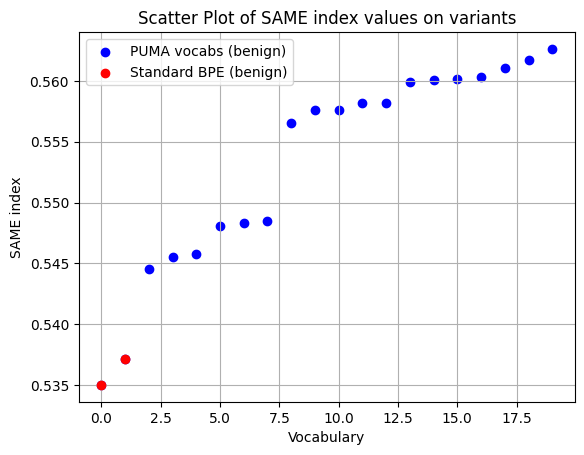

In [3]:
import matplotlib.pyplot as plt

# all_pairs1 = list(zip(value_list1, name_list1))
# all_pairs2 = list(zip(value_list2, name_list2))
# Prepare data
x = list(range(len(all_pairs1)))  # or use np.arange
y1 = [val["total_eq"]/len(val["rand"]) for val, name in all_pairs1]
y2 = [val["total_eq"]/len(val["rand"]) for val, name in all_pairs2]
# y1 = [val["mean_windowed_rand"] for val, name in all_pairs1]
# y2 = [val["mean_windowed_rand"] for val, name in all_pairs2]

# Extract the target
target_names1 = [name for val, name in all_pairs1 if "_bpe_" in name]
target_names2 = [name for val, name in all_pairs2 if "_bpe_" in name]
target_indices1 = [idx for idx, (val, name) in enumerate(all_pairs1) if name in target_names1]
target_indices2 = [idx for idx, (val, name) in enumerate(all_pairs2) if name in target_names2]
target_y1 = [y1[idx] for idx in target_indices1]
target_y2 = [y2[idx] for idx in target_indices2]


# Plot all points
plt.scatter(x, y1, label='PUMA vocabs (benign)', color='blue')
# plt.scatter(x, y2, label='PUMA vocab (patho)', color='lightblue')

# plt.scatter(x, [y1[idx] - y2[idx] for idx in range(len(y1))], label='Benign - Patho', color='blue')

# Highlight the target point
plt.scatter(target_indices1, target_y1, color='red', label="Standard BPE (benign)", zorder=5)
# plt.scatter(target_indices2, target_y2, color='pink', label="Standard BPE (patho)", zorder=5)

# plt.scatter(target_indices1, [target_y1[idx] - target_y2[idx] for idx in range(len(target_y1))], color='red', label="Benign - Patho (BPE only)", zorder=5)

# Optionally annotate
# plt.annotate("Standard BPE", (target_index, target_y), textcoords="offset points", xytext=(5,5), ha='left', color='red')

# Labeling
plt.xlabel("Vocabulary")
plt.ylabel("SAME index")
plt.title("Scatter Plot of SAME index values on variants")
plt.legend()
plt.grid(True)
plt.show()


(array([  166.,   122.,   308.,   137.,   692.,  1000.,   318.,  1661.,
         2076.,   594.,  1565.,  4086.,   331.,    80., 17288.]),
 array([0.985, 0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992, 0.993,
        0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.   ]),
 <BarContainer object of 15 artists>)

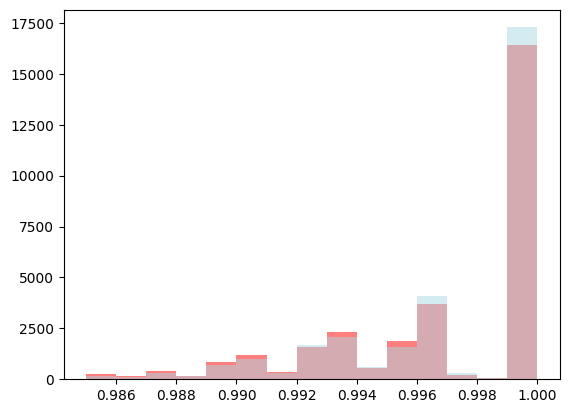

In [12]:

plt.hist(all_pairs1[0][0]["windowed_rand"], bins=np.arange(0.985, 1, 0.001), alpha=0.5, color='red', label='Data 1')
plt.hist(all_pairs1[-1][0]["windowed_rand"], bins=np.arange(0.985, 1, 0.001), alpha=0.5, color='lightblue', label='Data 2')